In [41]:
import h5py
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits import mplot3d 
import trimesh
# import pyrender

import pytorch3d
import torch
import pytorch3d.transforms

In [42]:
# filepath = "/Users/rahulmv/Desktop/Dominoes/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0124.hdf5"
filepath = "/mnt/fs3/rmvenkat/data/physion_data/dominoes_one/train/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom/0014.hdf5"
f = h5py.File(filepath)
name = filepath.split('/')[-1].split('.')[0]

In [43]:
def get_ax(fig):
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=30., azim=30, vertical_axis='y')
    return ax

def plot_box(pts, colors, close=False):
    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors)
    return fig
#     plt.close(fig)
# plot_box(vertices_orig, colors=[[0, 0, 1]])

def get_transformed_pts(pts, rotations, trans):
#     frame = str(frame).zfill(4)

    rot = R.from_quat(rotations).as_matrix()
    transformed_pts = np.matmul(rot, pts.T).T + np.expand_dims(trans, axis=0)
    
    return transformed_pts

import colorsys 
 
def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 
 
def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return np.array(list((HSVToRGB(huePartition * value, .4, .5) for value in range(0, n))))/255.0


def get_vertices_scaled(f, obj_id):
    
    vertices_orig = np.array(f['static']['mesh']['vertices_' + str(obj_id)])

    scales = f["static"]["scale"][:]

    vertices_orig[:,0] *= scales[obj_id, 0]
    vertices_orig[:,1] *= scales[obj_id, 1]
    vertices_orig[:,2] *= scales[obj_id, 2]
    faces_orig = np.array(f['static']['mesh']['faces_' + str(obj_id)])
    
    return vertices_orig, faces_orig
        
def draw3DRectangle(ax, x1, y1, z1, x2, y2, z2, color):
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     ax.set_zlim(-2, 2)
    # the Translate the datatwo sets of coordinates form the apposite diagonal points of a cuboid
    ax.plot([x1, x2], [y1, y1], [z1, z1], color=color) # | (up)
    ax.plot([x2, x2], [y1, y2], [z1, z1], color=color) # -->
    ax.plot([x2, x1], [y2, y2], [z1, z1], color=color) # | (down)
    ax.plot([x1, x1], [y2, y1], [z1, z1], color=color) # <--

    ax.plot([x1, x2], [y1, y1], [z2, z2], color=color) # | (up)
    ax.plot([x2, x2], [y1, y2], [z2, z2], color=color) # -->
    ax.plot([x2, x1], [y2, y2], [z2, z2], color=color) # | (down)
    ax.plot([x1, x1], [y2, y1], [z2, z2], color=color) # <--
    
    ax.plot([x1, x1], [y1, y1], [z1, z2], color=color) # | (up)
    ax.plot([x2, x2], [y2, y2], [z1, z2], color=color) # -->
    ax.plot([x1, x1], [y2, y2], [z1, z2], color=color) # | (down)
    ax.plot([x2, x2], [y1, y1], [z1, z2], color=color) # <--

def draw3DRectangleBox(ax, edges, pts, color):
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     ax.set_zlim(-2, 2)
    # the Translate the data two sets of coordinates form the apposite diagonal points of a cuboid
    for edge in edges:
        x1, y1, z1 = pts[edge[0]]
        x2, y2, z2 = pts[edge[1]]
        ax.plot([x1, x2], [y1, y2], [z1, z2], color=color) # | (up

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color=color)


def get_full_bbox(vertices):
    
    arr1 = vertices.min(0)
    
    arr2 = vertices.max(0)
    
    arr = np.stack([arr1, arr2], 0)
    
    pts = [(0, 0, 0), (0, 0, 1), (0, 1, 1), (0, 1, 0) , (1, 0, 0), (1, 0, 1), (1, 1, 1), (1, 1, 0)]
         
    all_edges = [(0, 1), (1, 2), (2, 3), (3, 0),  (4, 5), (5, 6), (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)]
    
    all_faces = [(0, 1, 2, 3), (4, 5, 6, 7), (2, 3, 6, 7), (1, 0, 4, 5), (1, 2, 6, 5), \
                (0, 4, 7, 3)]    
    
    index = np.arange(3)
    
    all_pts = []
    for pt in pts:
        p1 = arr[pt, index]
        all_pts.append(p1)
    
    all_pts = np.stack(all_pts, 0)
    
    return all_pts, all_edges, all_faces   

def scatter_pts(pts):
    
    fig = plt.figure()    
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2])
    return

import torch

from torch import nn
from torch import Tensor


class GeodesicLoss(nn.Module):
    r"""Creates a criterion that measures the distance between rotation matrices, which is
    useful for pose estimation problems.
    The distance ranges from 0 to :math:`pi`.
    See: http://www.boris-belousov.net/2016/12/01/quat-dist/#using-rotation-matrices and:
    "Metrics for 3D Rotations: Comparison and Analysis" (https://link.springer.com/article/10.1007/s10851-009-0161-2).
    Both `input` and `target` consist of rotation matrices, i.e., they have to be Tensors
    of size :math:`(minibatch, 3, 3)`.
    The loss can be described as:
    .. math::
        \text{loss}(R_{S}, R_{T}) = \arccos\left(\frac{\text{tr} (R_{S} R_{T}^{T}) - 1}{2}\right)
    Args:
        eps (float, optional): term to improve numerical stability (default: 1e-7). See:
            https://github.com/pytorch/pytorch/issues/8069.
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will
            be applied, ``'mean'``: the weighted mean of the output is taken,
            ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in
            the meantime, specifying either of those two args will override
            :attr:`reduction`. Default: ``'mean'``
    Shape:
        - Input: :math:`(N, 3, 3)`.
        - Target: :math:`(N, 3, 3)`.
        - Output: scalar.
          If :attr:`reduction` is ``'none'``, then :math:`(N)`.
    """

    def __init__(self, eps: float = 1e-7, reduction: str = "mean") -> None:
        super().__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        R_diffs = input @ target.permute(0, 2, 1)
        # See: https://github.com/pytorch/pytorch/issues/7500#issuecomment-502122839.
        traces = R_diffs.diagonal(dim1=-2, dim2=-1).sum(-1)
        dists = torch.acos(torch.clamp((traces - 1) / 2, -1 + self.eps, 1 - self.eps))
        if self.reduction == "none":
            return dists
        elif self.reduction == "mean":
            return dists.mean()
        elif self.reduction == "sum":
            return dists.sum()

from sympy import *
def asCartesian(rthetaphi):
    #takes list rthetaphi (single coord)
    r       = rthetaphi[0]
    theta   = rthetaphi[1]* pi/180 # to radian
    phi     = rthetaphi[2]* pi/180
    x = r * sin( theta ) * cos( phi )
    y = r * sin( theta ) * sin( phi )
    z = r * cos( theta )
    return [x,y,z]

def asSpherical(xyz):
    #takes list xyz (single coord)
    x       = xyz[0]
    y       = xyz[1]
    z       = xyz[2]
    r       =  sqrt(x*x + y*y + z*z)
    theta   =  acos(z/r)*180/ pi #to degrees
    phi     =  atan2(y,x)*180/ pi
    return [r,theta,phi]

from scipy.spatial.transform import Rotation as R
import transforms3d.euler as eul


def norm(vector):
    return vector/np.sqrt(np.sum(vector**2) + 1e-8)
    
def get_rotation(pts):
    
    x_axis = norm(pts[4] - pts[0])
    y_axis = norm(pts[2] - pts[1])
    z_axis = norm(pts[1] - pts[0])
    
    rotation_matrix = np.stack([x_axis, y_axis, z_axis], 0)
    
    euler_angles = pytorch3d.transforms.matrix_to_euler_angles(torch.tensor(rotation_matrix), 'XYZ')
    
#     eul.mat2euler(rotation_matrix, axes='sxyz')
    
    mat = pytorch3d.transforms.euler_angles_to_matrix(euler_angles, 'XYZ').numpy()
    
    
    
#     mat = eul.euler2mat(euler_angles[0], euler_angles[1], euler_angles[2], axes='sxyz')

    assert abs(np.sum(np.matmul(rotation_matrix, rotation_matrix.T)) - 3) < 1e-3

#     print("diff", np.mean((mat - rotation_matrix)**2))
    
    return euler_angles.numpy()

def decode(centroid, euler_angles, size):
    
    mat = pytorch3d.transforms.euler_angles_to_matrix(torch.tensor(euler_angles), 'XYZ').numpy()
    
    pts = [(-1, -1, -1), (-1, -1, 1), (-1, 1, 1), (-1, 1, -1), (1, -1, -1), (1, -1, 1), (1, 1, 1), (1, 1, -1)]

    all_edges = [(0, 1), (1, 2), (2, 3), (3, 0),  (4, 5), (5, 6), (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)]

    all_faces = [(0, 1, 2, 3), (4, 5, 6, 7), (2, 3, 6, 7), (1, 0, 4, 5), (1, 2, 6, 5), \
                (0, 4, 7, 3)]    

    all_pts = []
    for pt in pts:
        p1 = centroid + np.matmul(mat.T, size*pt)
        all_pts.append(p1)

    all_pts = np.stack(all_pts, 0)

    return all_pts, all_edges, all_faces 
        


def get_bbox_encoding_seq(f, subsample, viz=False):
    
    reject = np.array(f['static']['model_names']) != b'cube'

    object_ids = np.arange(len(f['static']['object_ids']))

    colors = [[0, 1, 0], [1, 0, 0]]
    
    if len(object_ids) > 2:
        colors += list(getDistinctColors(len(object_ids)-2))

    #NOTE THE FIRST OBJECT IS ALWAYS THE PATIENT
    frame_no = 0

    # %matplotlib notebook
    # %matplotlib notebook

    # %matplotlib inline

    all_imgs = []
    
    all_encodings = []

    for frame_no in range(0, len(f['frames']), subsample):

        frame = str(frame_no).zfill(4)
        
        if viz:

            fig = plt.figure(figsize=[10, 10])
            ax = get_ax(fig)
        
        all_obj_pts = []
        
        for obj_id in object_ids:

#             obj_id = obj_id-1    

            if not reject[obj_id]:

                vertices_orig, faces_orig = get_vertices_scaled(f, obj_id)

                size = np.max(vertices_orig, 0) - np.min(vertices_orig, 0)

                size /= 2

                rotations = np.array(f['frames'][frame]['objects']['rotations'][obj_id])
                trans = np.array(f['frames'][frame]['objects']['positions'][obj_id])

                all_pts, all_edges, all_faces = get_full_bbox(vertices_orig)
                
                frame_pts = get_transformed_pts(all_pts, rotations, trans)

                centroid = np.mean(frame_pts, 0)

                euler_angles = get_rotation(frame_pts)

                encoding = [centroid, euler_angles, size]
                
                all_obj_pts.append(np.array(np.concatenate(encoding)))

                all_pts_, all_edges_, all_faces_ = decode(centroid, euler_angles, size)

    #             print("err", np.mean((all_pts_ - frame_pts)**2))
                if viz: 
                    draw3DRectangleBox(ax, all_edges_, all_pts_, colors[obj_id])

    #             break

#         break
        all_obj_pts = np.stack(all_obj_pts, 0)
    
        all_encodings.append(all_obj_pts)
        
        if viz:
            fig.savefig('temp.png')

            plt.close(fig)

            img = plt.imread('temp.png')

            all_imgs.append(img)
    
    all_encodings = np.stack(all_encodings, 0)
    
    if viz: 
        return all_encodings, all_imgs
    
    return all_encodings

In [44]:
import time 
t = time.time()
all_encodings = get_bbox_encoding_seq(f, 6)
print(time.time() - t)

0.389345645904541


In [45]:
%matplotlib inline
import time 
t = time.time()
all_encodings, all_imgs = get_bbox_encoding_seq(f, 1, True)
print(time.time() - t)

33.52073311805725


In [46]:
f['static'].keys()

<KeysViewHDF5 ['bounciness', 'color', 'distractors', 'dynamic_friction', 'git_commit', 'initial_position', 'initial_rotation', 'mass', 'mesh', 'model_names', 'object_ids', 'object_segmentation_colors', 'occluders', 'probe_id', 'probe_mass', 'probe_type', 'push_force', 'push_position', 'push_time', 'randomize', 'remove_middle', 'room', 'scale', 'scale_x', 'scale_y', 'scale_z', 'seed', 'static_friction', 'stimulus_name', 'target_id', 'target_rotation', 'target_type', 'trial_num', 'trial_seed', 'zone_id']>

In [47]:
np.array(f['static']['object_ids'])

array([1, 3])

In [48]:
import subprocess
import cv2
def write_video(file_path, frames, fps):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    """

    h, w = frames[0].shape[:2]
    fourcc = cv2.cv2.VideoWriter_fourcc(*"MJPG")# cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write((frame[:, :, :3]*255).astype('uint8'))

    writer.release() 

In [49]:
write_video(name + '_dec.avi', all_imgs, 30)

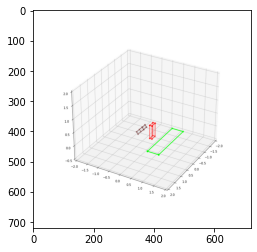

In [370]:
plt.imshow(all_imgs[0])

**what do the rot and trans mean??**

In [ ]:
vertices_orig, faces_orig = get_vertices_scaled(1)

np.max(vertices_orig, 0) - np.min(vertices_orig, 0)

trans = np.array(f['frames']['0150']['objects']['positions'][1])

rotations = np.array(f['frames']['0150']['objects']['rotations'][1])

rotations, trans

d = np.sqrt(np.sum(rotations[:3]**2))
rotations[:3]/d

d

2*np.arctan2(d, rotations[3])*180/3.14385